##**Fine-Tune BERT-Based Models for Sentiment Analysis**

### **Imports Necessary Libraries**

https://www.kaggle.com/code/iamolivia/financial-sentiment-analysis-bert/data

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd

import random
from tqdm import tqdm

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_warning()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

!pip install wandb
import wandb

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
wandb.require("service")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Imports Kaggle/ Financial News Preprocessed Dataset**

In [ ]:
df = pd.read_pickle('pre-processed_finance_news.pkl')
df.head()

,Sentiment,Sentence
0,positive,geosolutions technology leverage benefon gps s...
1,negative,esi lows bk real possibility
2,positive,last quarter componenta net sales doubled eur1...
3,neutral,according finnish russian chamber commerce maj...
4,neutral,swedish buyout firm sold remaining percent sta...


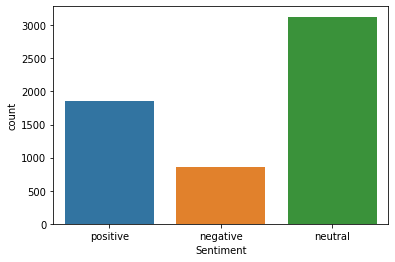

In [ ]:
# show the distribution of the labels
sns.countplot(x=df.Sentiment);

### **Fine-Tune BERT**

In [ ]:
# label encode the targets
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)
labels

array([2, 0, 2, ..., 1, 1, 2])

In [ ]:
# show the encoder classes
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# encode sample sentence
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# divide data into train (50%), val (10%), test (10%)
X_train, X_val_test, y_train, y_val_test = train_test_split(df.Sentence.values, labels, test_size=.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4673,), (4673,), (584,), (584,), (585,), (585,))

In [ ]:
#Investigate for the maximum pad length
max_len = 0 

for sent in df.Sentence.values:
  #tokenize the text and add 'CLS' and 'SEP' tokens
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  max_len= max(max_len, len(input_ids))

print('Max sentences lenght: ', max_len)

Max sentences lenght:  111


In [ ]:
# set parameter
MAX_LEN = 111
BATCH_SIZE = 16
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 10
num_classes = 3

In [ ]:
# create dataset
class FinancialDataset(Dataset):
    def __init__(self, sentences, target, tokenizer, max_len):
        self.sentences = sentences
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        # encode input sentence
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [ ]:
# create dataloader
train_dataset = FinancialDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset = FinancialDataset(X_val, y_val, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset = FinancialDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
# create classifier
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.BertModel = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.BertModel.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.BertModel(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
# function to calculate average 
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [ ]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [ ]:
def run():
    # Load pretrained model
    model = SentimentClassifier(num_classes)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'best_BERT.pth')
    return log

In [ ]:
log = run()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 37/37 [00:01<00:00, 18.94it/s, accuracy=0.735, epoch=10, loss=0.795]


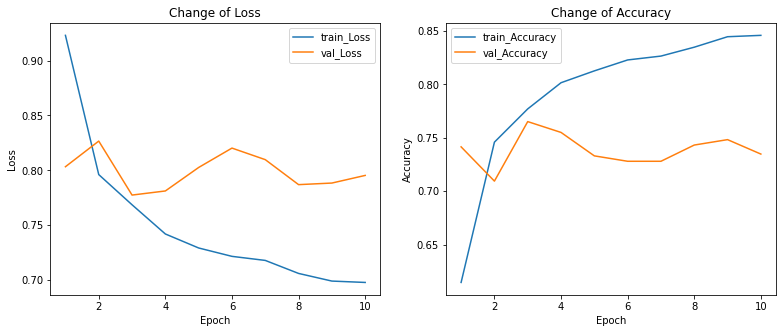

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    sns.lineplot(y=train_value,x=range(1,EPOCH+1),ax=ax,label=f'train_{label}')
    sns.lineplot(y=val_value,x=range(1,EPOCH+1),ax=ax,label=f'val_{label}')
    ax.set_title(f'Change of {label}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')


In [ ]:
# load weight with best val loss
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('./best_BERT.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()
    
    labels = []
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        
        labels.append(targets.item())
        predictions.append(pred.item())
    return labels, predictions

In [ ]:
# predict test dataset
labels, preds = test_fn(test_dataset, model, device)


100%|██████████| 585/585 [00:07<00:00, 83.16it/s]


In [ ]:
print(f'Label\t\t:{labels[:10]}')
print(f'Prediction\t:{preds[:10]}')

Label		:[1, 0, 2, 2, 2, 1, 0, 1, 2, 1]
Prediction	:[1, 1, 0, 1, 1, 1, 1, 2, 2, 1]


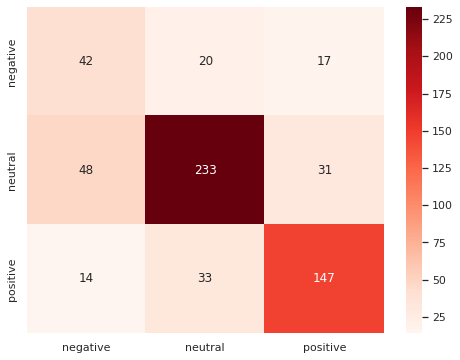

In [ ]:
# visualize predictions
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
cf_matrix = confusion_matrix(labels, preds)
sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=encoder.classes_,yticklabels=encoder.classes_);

In [ ]:
label_preds = encoder.inverse_transform(preds)
label_targets = encoder.inverse_transform(labels)

In [ ]:
print(classification_report(label_targets,label_preds))

              precision    recall  f1-score   support

    negative       0.40      0.53      0.46        79
     neutral       0.81      0.75      0.78       312
    positive       0.75      0.76      0.76       194

    accuracy                           0.72       585
   macro avg       0.66      0.68      0.66       585
weighted avg       0.74      0.72      0.73       585



In [ ]:
from transformers import RobertaConfig, RobertaModel

In [ ]:
# label encode the targets
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)
labels

array([2, 0, 2, ..., 1, 1, 2])

### **Fine-Tune RoBERTa**

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
# label encode the targets
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)
labels

array([2, 0, 2, ..., 1, 1, 2])

In [ ]:
# encode sample sentence
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# divide data into train (50%), val (10%), test (10%)
X_train, X_val_test, y_train, y_val_test = train_test_split(df.Sentence.values, labels, test_size=.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4673,), (4673,), (584,), (584,), (585,), (585,))

In [ ]:
#Investigate for the maximum pad length
max_len = 0 

for sent in df.Sentence.values:
  #tokenize the text and add 'CLS' and 'SEP' tokens
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  max_len= max(max_len, len(input_ids))

print('Max sentences lenght: ', max_len)

Max sentences lenght:  96


In [ ]:
# set parameter
MAX_LEN = 96
BATCH_SIZE = 16
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 10
num_classes = 3

In [ ]:
# create dataset
class FinancialDataset(Dataset):
    def __init__(self, sentences, target, tokenizer, max_len):
        self.sentences = sentences
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        # encode input sentence
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [ ]:
# create dataloader
train_dataset = FinancialDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset = FinancialDataset(X_val, y_val, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset = FinancialDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
# create classifier
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
# function to calculate average 
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [ ]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [ ]:
def run():
    # Load pretrained model
    model = SentimentClassifier(num_classes)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'best_RoBERTa.pth')
            torch.save(model, f'MODEL_BERT.pth')
    return log

In [ ]:
log = run()

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 37/37 [00:01<00:00, 19.33it/s, accuracy=0.747, epoch=10, loss=0.8]


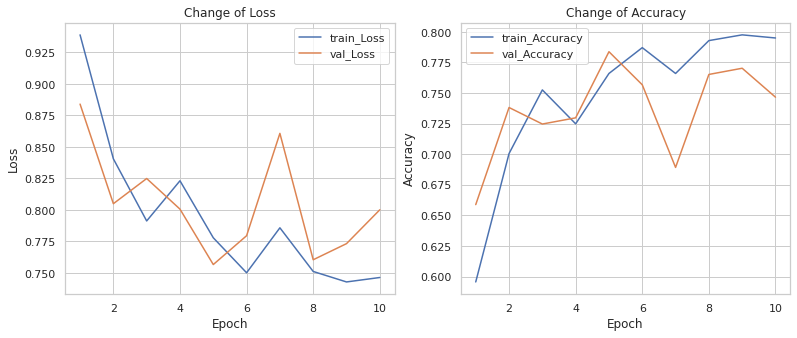

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    sns.lineplot(y=train_value,x=range(1,EPOCH+1),ax=ax,label=f'train_{label}')
    sns.lineplot(y=val_value,x=range(1,EPOCH+1),ax=ax,label=f'val_{label}')
    ax.set_title(f'Change of {label}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')
plt.savefig('RoBERTa.png', dpi=300);

In [ ]:
# load weight with best val loss
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('./best_RoBERTa.pth'))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()
    
    labels = []
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        
        labels.append(targets.item())
        predictions.append(pred.item())
    return labels, predictions

In [ ]:
# predict test dataset
labels, preds = test_fn(test_dataset, model, device)


100%|██████████| 585/585 [00:06<00:00, 85.96it/s]


In [ ]:
print(f'Label\t\t:{labels[:10]}')
print(f'Prediction\t:{preds[:10]}')

Label		:[1, 0, 2, 2, 2, 1, 0, 1, 2, 1]
Prediction	:[1, 1, 2, 1, 1, 1, 1, 2, 2, 1]


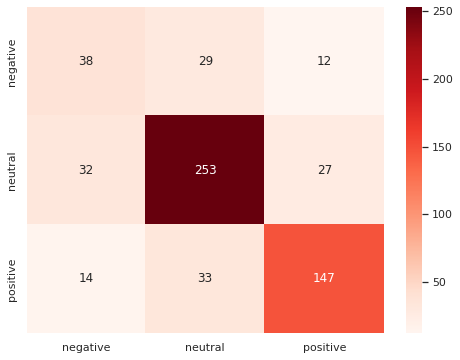

In [ ]:
# visualize predictions
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
cf_matrix = confusion_matrix(labels, preds)
sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=encoder.classes_,yticklabels=encoder.classes_);

In [ ]:
label_preds = encoder.inverse_transform(preds)
label_targets = encoder.inverse_transform(labels)

In [ ]:
print(classification_report(label_targets,label_preds))

              precision    recall  f1-score   support

    negative       0.45      0.48      0.47        79
     neutral       0.80      0.81      0.81       312
    positive       0.79      0.76      0.77       194

    accuracy                           0.75       585
   macro avg       0.68      0.68      0.68       585
weighted avg       0.75      0.75      0.75       585



###**Label temporary Tweets Dataset that reference to DELL Technology Company using RoBERTa from HuggingFace**

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0a51b0e4a4ad16a2ec9f8119267c62d9e992a2df7c7dda7503d9f76380c1a958
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import torch
import wget
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
import string
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, AlbertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np

MODEL = "roberta-base"
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
df = pd.read_pickle('pre-processed_finance_tweets.pkl')
df.head()

,date,text,mentions,tags,text_clean,text_tokens,text_tokens_lem,text_new,text_length,cleaned_text_length
0,2022-06-26 16:40:18,vmware dell starting one important security co...,[],"[Dell, VMware]",Starting with one of the most important securi...,"[starting, one, important, security, controls,...","[starting, one, important, security, control, ...","[vmware, dell, starting, one, important, secur...",208,28
1,2022-06-26 16:36:23,miss new series detailing major prem amp cloud...,"[dvellante, MasSubestimado, furrier]",[Dell],Don’t miss this new series detailing major on-...,"[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...",220,35
2,2022-06-26 16:31:24,got shiki rolled want waking pc lol pc pcsetup...,[],"[shikimorisnotjustacutie, logitechg, pc, light...",got shiki-rolled when I want to waking up my P...,"[got, shiki, rolled, want, waking, pc, lol]","[got, shiki, rolled, want, waking, pc, lol]","[got, shiki, rolled, want, waking, pc, lol, pc...",176,24
3,2022-06-26 16:14:33,dell inspiron offers ok productivity performan...,[],"[Dell, Inspiron]",The 14 2-in-1 offers OK productivity performan...,"[offers, ok, productivity, performance, displa...","[offer, ok, productivity, performance, display...","[dell, inspiron, offers, ok, productivity, per...",76,10
4,2022-06-26 16:12:29,miss new series detailing major prem amp cloud...,"[dvellante, MasSubestimado, furrier]",[Dell],Don’t miss this new series detailing major on-...,"[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...",220,35


In [ ]:
df.rename(columns = {'text_Preprocessed' : 'Sentenece'}, inplace = True)

In [ ]:
df_sentiment = []
count = 0 
target = len(df)
for tweet in range(len(df)):
  df_sentiment.append(sentiment_task(df['text_new'][tweet]))
  print("Completed {}/{}".format(count,target))
  count = count+1
  target = target-1

Completed 0/600
Completed 1/599
Completed 2/598
Completed 3/597
Completed 4/596
Completed 5/595
Completed 6/594
Completed 7/593
Completed 8/592
Completed 9/591
Completed 10/590
Completed 11/589
Completed 12/588
Completed 13/587
Completed 14/586
Completed 15/585
Completed 16/584
Completed 17/583
Completed 18/582
Completed 19/581
Completed 20/580
Completed 21/579
Completed 22/578
Completed 23/577
Completed 24/576
Completed 25/575
Completed 26/574
Completed 27/573
Completed 28/572
Completed 29/571
Completed 30/570
Completed 31/569
Completed 32/568
Completed 33/567
Completed 34/566
Completed 35/565
Completed 36/564
Completed 37/563
Completed 38/562
Completed 39/561
Completed 40/560
Completed 41/559
Completed 42/558
Completed 43/557
Completed 44/556
Completed 45/555
Completed 46/554
Completed 47/553
Completed 48/552
Completed 49/551
Completed 50/550
Completed 51/549
Completed 52/548
Completed 53/547
Completed 54/546
Completed 55/545
Completed 56/544
Completed 57/543
Completed 58/542
Complet

In [ ]:
df = df.drop(labels=['text', 'mentions','tags','text_tokens','text_tokens_lem','text_new','text_length','cleaned_text_length'], axis=1)

In [ ]:
df_sentiment_new = pd.DataFrame.from_dict(df_sentiment)

In [ ]:
label_list = [] 
score_list = []
for i in range(len(df_sentiment_new)):
  label_list.append(df_sentiment_new[0][i]['label'])
  score_list.append(df_sentiment_new[0][i]['score'])

df_label = pd.DataFrame(label_list)
df_score = pd.DataFrame(score_list)

df_label.columns = ['sentiment']
df_score.columns = ['score']

df_result = pd.concat([df_label, df_score], axis=1)

df_tweet = pd.concat([df, df_result], axis=1)

df_tweet

,date,text_clean,sentiment,score
0,2022-06-26 16:40:18,Starting with one of the most important securi...,Neutral,0.787881
1,2022-06-26 16:36:23,Don’t miss this new series detailing major on-...,Neutral,0.587020
2,2022-06-26 16:31:24,got shiki-rolled when I want to waking up my P...,Neutral,0.629367
3,2022-06-26 16:14:33,The 14 2-in-1 offers OK productivity performan...,Neutral,0.783610
4,2022-06-26 16:12:29,Don’t miss this new series detailing major on-...,Neutral,0.587020
...,...,...,...,...
595,2022-06-21 06:30:07,While your Inspiron 2-in-1 can get pretty flex...,Neutral,0.644122
596,2022-06-21 06:20:32,International Yoga day with Dell Laptop,Neutral,0.664358
597,2022-06-21 06:06:28,"Laptop for sale Dell Inspiron 3576 I3, 7th gen...",Neutral,0.694285
598,2022-06-21 05:16:05,International yoga day Connect with us on Face...,Neutral,0.664358


In [ ]:
df_tweet

,date,text_clean,sentiment,score
0,2022-06-26 16:40:18,Starting with one of the most important securi...,Neutral,0.787881
1,2022-06-26 16:36:23,Don’t miss this new series detailing major on-...,Neutral,0.587020
2,2022-06-26 16:31:24,got shiki-rolled when I want to waking up my P...,Neutral,0.629367
3,2022-06-26 16:14:33,The 14 2-in-1 offers OK productivity performan...,Neutral,0.783610
4,2022-06-26 16:12:29,Don’t miss this new series detailing major on-...,Neutral,0.587020
...,...,...,...,...
595,2022-06-21 06:30:07,While your Inspiron 2-in-1 can get pretty flex...,Neutral,0.644122
596,2022-06-21 06:20:32,International Yoga day with Dell Laptop,Neutral,0.664358
597,2022-06-21 06:06:28,"Laptop for sale Dell Inspiron 3576 I3, 7th gen...",Neutral,0.694285
598,2022-06-21 05:16:05,International yoga day Connect with us on Face...,Neutral,0.664358


###**Use the best fine-tuned pre-trained dataset to Annotate the DELL Technology Company**




In [ ]:
from transformers import RobertaTokenizer, RobertaModel


In [ ]:
df = pd.read_pickle('pre-processed_finance_tweets.pkl')
df.head()

,date,text,mentions,tags,text_clean,text_tokens,text_tokens_lem,text_new,text_length,cleaned_text_length
0,2022-06-26 16:40:18,vmware dell starting one important security co...,[],"[Dell, VMware]",Starting with one of the most important securi...,"[starting, one, important, security, controls,...","[starting, one, important, security, control, ...","[vmware, dell, starting, one, important, secur...",208,28
1,2022-06-26 16:36:23,miss new series detailing major prem amp cloud...,"[dvellante, MasSubestimado, furrier]",[Dell],Don’t miss this new series detailing major on-...,"[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...",220,35
2,2022-06-26 16:31:24,got shiki rolled want waking pc lol pc pcsetup...,[],"[shikimorisnotjustacutie, logitechg, pc, light...",got shiki-rolled when I want to waking up my P...,"[got, shiki, rolled, want, waking, pc, lol]","[got, shiki, rolled, want, waking, pc, lol]","[got, shiki, rolled, want, waking, pc, lol, pc...",176,24
3,2022-06-26 16:14:33,dell inspiron offers ok productivity performan...,[],"[Dell, Inspiron]",The 14 2-in-1 offers OK productivity performan...,"[offers, ok, productivity, performance, displa...","[offer, ok, productivity, performance, display...","[dell, inspiron, offers, ok, productivity, per...",76,10
4,2022-06-26 16:12:29,miss new series detailing major prem amp cloud...,"[dvellante, MasSubestimado, furrier]",[Dell],Don’t miss this new series detailing major on-...,"[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...","[miss, new, series, detailing, major, prem, am...",220,35


In [ ]:
# label encode the targets
encoder = LabelEncoder()
labels = encoder.fit_transform(df_tweet.sentiment)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# encode sample sentence
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# divide data into train (50%), val (10%), test (10%)
X_train, X_val_test, y_train, y_val_test = train_test_split(df.text_clean.values, labels, test_size=.99, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.99, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6,), (6,), (5,), (5,), (589,), (589,))

In [ ]:
# set parameter
MAX_LEN = 50
BATCH_SIZE = 16
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 20
num_classes = 3

In [ ]:
# create dataset
class FinancialDataset(Dataset):
    def __init__(self, sentences, target, tokenizer, max_len):
        self.sentences = sentences
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        # encode input sentence
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [ ]:
# create dataloader
train_dataset = FinancialDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset = FinancialDataset(X_val, y_val, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset = FinancialDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
# create classifier
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
# function to calculate average 
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [ ]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [ ]:
def run():
    # Load pretrained model
    model = SentimentClassifier(num_classes)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'best_RoBERTa.pth')
            torch.save(model, f'MODEL_BERT.pth')
    return log

In [ ]:
# load weight with best val loss
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('./best_RoBERTa.pth'))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()
    
    labels = []
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        
        labels.append(targets.item())
        predictions.append(pred.item())
    return labels, predictions

In [ ]:
labels, preds = test_fn(test_dataset, model, device)

  0%|          | 0/589 [00:00<?, ?it/s]

In [ ]:
print(f'Label\t\t:{labels}')
len(preds)

Label		:[1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

589

In [ ]:
df_last = df_tweet.tail(589)


In [ ]:
df_preds = pd.DataFrame(preds)

In [ ]:
len(df_last), len(df_preds)

(589, 589)

In [ ]:
len(df_tweet)

600

In [ ]:
df_last['Sentiment_Prediction'] = preds


In [ ]:
df_last=df_last.drop(['sentiment'], axis=1)

In [ ]:
df_last

,date,text_clean,score,Sentiment_Prediction
11,2022-06-26 14:31:02,Tune in on June 30 at 12 PM EDT for the interv...,0.641823,1
12,2022-06-26 14:12:06,C$34.49 - | Amazing deals at amazing low price...,0.457295,2
13,2022-06-26 14:02:03,Wanted used servers Cisco laptops computers ne...,0.638390,1
14,2022-06-26 13:48:13,"C$499.99 - | Shop more, save more Dell 27 LED ...",0.457295,1
15,2022-06-26 13:39:08,/deals/make-the-switch-to-windows-11-with-hund...,0.616916,1
...,...,...,...,...
595,2022-06-21 06:30:07,While your Inspiron 2-in-1 can get pretty flex...,0.644122,1
596,2022-06-21 06:20:32,International Yoga day with Dell Laptop,0.664358,1
597,2022-06-21 06:06:28,"Laptop for sale Dell Inspiron 3576 I3, 7th gen...",0.694285,1
598,2022-06-21 05:16:05,International yoga day Connect with us on Face...,0.664358,1


In [ ]:
df_last=df_last.drop(['score'], axis=1)

In [ ]:
sentiment_descr = []

for i in range(len(df_last)):
  if (df_last['Sentiment_Prediction'].iloc[i] == 0):
    sentiment_descr.append('Positive') 
  elif (df_last['Sentiment_Prediction'].iloc[i] == 1):
    sentiment_descr.append('Neutral') 
  elif (df_last['Sentiment_Prediction'].iloc[i] == 2):
    sentiment_descr.append('Negative') 
  

1
2
1
1
1
1
2
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
2
2
1
1
1
1
1
1
0
1
1
1
1
1
2
1
2
1
1
1
1
2
1
0
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
0
1
1
2
2
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
2
2
1
1
1
2
1
2
2
2
1
1
2
1
2
1
1
1
2
1
1
1
2
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
2
2
2
2
1
1
1
1
2
1
2
2
1
2
1
1
1
1
1
1
2
1
1
2
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
2
1
2
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
2
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
2
1
1
1
0
1
0
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1


In [ ]:
df_last['Sentiment_Description'] = sentiment_descr

In [ ]:
df_last

,date,text_clean,Sentiment_Prediction,Sentiment_Description
11,2022-06-26 14:31:02,Tune in on June 30 at 12 PM EDT for the interv...,1,Neutral
12,2022-06-26 14:12:06,C$34.49 - | Amazing deals at amazing low price...,2,Negative
13,2022-06-26 14:02:03,Wanted used servers Cisco laptops computers ne...,1,Neutral
14,2022-06-26 13:48:13,"C$499.99 - | Shop more, save more Dell 27 LED ...",1,Neutral
15,2022-06-26 13:39:08,/deals/make-the-switch-to-windows-11-with-hund...,1,Neutral
...,...,...,...,...
595,2022-06-21 06:30:07,While your Inspiron 2-in-1 can get pretty flex...,1,Neutral
596,2022-06-21 06:20:32,International Yoga day with Dell Laptop,1,Neutral
597,2022-06-21 06:06:28,"Laptop for sale Dell Inspiron 3576 I3, 7th gen...",1,Neutral
598,2022-06-21 05:16:05,International yoga day Connect with us on Face...,1,Neutral


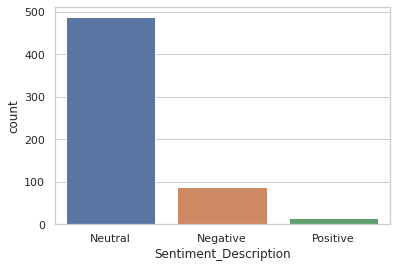

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment_Description', data=df_last)

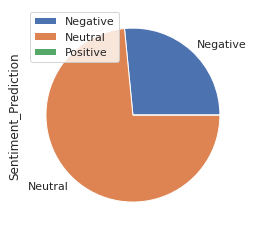

In [ ]:
import matplotlib.pyplot as  plt
df_last.groupby(['Sentiment_Description']).sum().plot(kind='pie', y='Sentiment_Prediction')

## **CEO Topic Sentiment Analysis**

In [ ]:
df = pd.read_pickle('business_tweets (1).pkl')
df.head()

,username,id,date,tweet,retweets,likes,mentions,tags,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,tweet_new_str,Topic,Topic_Id
16234,@MichaelDell,1.520000e+18,4/28/2022 18:22,Here are the similarities and differences betw...,1163.0,19662.0,"[Dell, Twitter, elonmusk]",[],Here are the similarities and differences betw...,"[similarities, differences, take, private, tak...","[similarity, difference, take, private, take, ...","[similarities, differences, elonmusk, take, pr...","similarities,differences,elonmusk,take,private...",Dell Technology,1
16235,@MichaelDell,1.520000e+18,4/22/2022 22:19,Making infrastructure available for our custom...,8.0,53.0,[DellTech],[],Making infrastructure available for our custom...,"[making, infrastructure, available, customers,...","[making, infrastructure, available, customer, ...","[making, infrastructure, available, customers,...","making,infrastructure,available,customers,solu...",Business,2
16237,@MichaelDell,1.520000e+18,4/22/2022 21:16,At @DellTech we're committed to building a bet...,6.0,63.0,[DellTech],[],At we're committed to building a better world ...,"[committed, building, better, world, customers...","[committed, building, better, world, customer,...","[delltech, committed, building, better, world,...","delltech,committed,building,better,world,custo...",Business,2
16240,@MichaelDell,1.510000e+18,4/14/2022 0:17,Our @DellTechPartner teams have played a key r...,24.0,158.0,"[DellTechPartner, DellTech]",[],Our teams have played a key role in our contin...,"[teams, played, key, role, continued, success,...","[team, played, key, role, continued, success, ...","[delltechpartner, teams, played, key, role, co...","delltechpartner,teams,played,key,role,continue...",Dell Technology,1
16241,@MichaelDell,1.510000e+18,4/14/2022 0:09,RT @DellStorage: Get ready to unleash a modern...,60.0,0.0,[DellStorage],[DellTechWorld],RT : Get ready to unleash a modern storage exp...,"[get, ready, unleash, modern, storage, experie...","[get, ready, unleash, modern, storage, experie...","[dellstorage, get, ready, unleash, modern, sto...","dellstorage,get,ready,unleash,modern,storage,e...",Dell Technology,1


In [ ]:
#Make string tweet_new column  
df['tweet_new_str'] = [','.join(map(str, l)) for l in df['tweet_new']]

### **Label temporary Tweets Dataset that reference to Michael Dell using RoBERTa from HuggingFace**

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np

model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sentiment = []
count = 0 
target = len(df)
for tweet in range(len(df)):
  df_sentiment.append(sentiment_task(df['tweet_new_str'].iloc[tweet]))
  print("Completed {}/{}".format(count,target))
  count = count+1
  target = target-1

Completed 0/2104
Completed 1/2103
Completed 2/2102
Completed 3/2101
Completed 4/2100
Completed 5/2099
Completed 6/2098
Completed 7/2097
Completed 8/2096
Completed 9/2095
Completed 10/2094
Completed 11/2093
Completed 12/2092
Completed 13/2091
Completed 14/2090
Completed 15/2089
Completed 16/2088
Completed 17/2087
Completed 18/2086
Completed 19/2085
Completed 20/2084
Completed 21/2083
Completed 22/2082
Completed 23/2081
Completed 24/2080
Completed 25/2079
Completed 26/2078
Completed 27/2077
Completed 28/2076
Completed 29/2075
Completed 30/2074
Completed 31/2073
Completed 32/2072
Completed 33/2071
Completed 34/2070
Completed 35/2069
Completed 36/2068
Completed 37/2067
Completed 38/2066
Completed 39/2065
Completed 40/2064
Completed 41/2063
Completed 42/2062
Completed 43/2061
Completed 44/2060
Completed 45/2059
Completed 46/2058
Completed 47/2057
Completed 48/2056
Completed 49/2055
Completed 50/2054
Completed 51/2053
Completed 52/2052
Completed 53/2051
Completed 54/2050
Completed 55/2049
Co

In [ ]:
df_sentiment

[[{'label': 'Neutral', 'score': 0.8269250392913818}],
 [{'label': 'Positive', 'score': 0.8237234950065613}],
 [{'label': 'Positive', 'score': 0.8617003560066223}],
 [{'label': 'Positive', 'score': 0.8412954211235046}],
 [{'label': 'Positive', 'score': 0.9225436449050903}],
 [{'label': 'Positive', 'score': 0.9663885235786438}],
 [{'label': 'Positive', 'score': 0.5378667712211609}],
 [{'label': 'Positive', 'score': 0.9025353789329529}],
 [{'label': 'Positive', 'score': 0.9446786046028137}],
 [{'label': 'Neutral', 'score': 0.5138812065124512}],
 [{'label': 'Positive', 'score': 0.8991467952728271}],
 [{'label': 'Neutral', 'score': 0.7258033156394958}],
 [{'label': 'Neutral', 'score': 0.5963136553764343}],
 [{'label': 'Negative', 'score': 0.49902182817459106}],
 [{'label': 'Positive', 'score': 0.975307822227478}],
 [{'label': 'Neutral', 'score': 0.6529563069343567}],
 [{'label': 'Positive', 'score': 0.8565828204154968}],
 [{'label': 'Neutral', 'score': 0.7752203345298767}],
 [{'label': 'Pos

In [ ]:
df_sentiment_new = pd.DataFrame.from_dict(df_sentiment)

In [ ]:
label_list = [] 
score_list = []
for i in range(len(df_sentiment_new)):
  label_list.append(df_sentiment_new[0][i]['label'])
  score_list.append(df_sentiment_new[0][i]['score'])

df_label = pd.DataFrame(label_list)
df_score = pd.DataFrame(score_list)

df_label.columns = ['sentiment']
df_score.columns = ['score']

df_result = pd.concat([df_label, df_score], axis=1)



In [ ]:
df['sentiment'] = label_list
df['score'] = score_list

In [ ]:
df

,username,id,date,tweet,retweets,likes,mentions,tags,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,tweet_new_str,Topic,Topic_Id,sentiment,score
16234,@MichaelDell,1.520000e+18,4/28/2022 18:22,Here are the similarities and differences betw...,1163.0,19662.0,"[Dell, Twitter, elonmusk]",[],Here are the similarities and differences betw...,"[similarities, differences, take, private, tak...","[similarity, difference, take, private, take, ...","[similarities, differences, elonmusk, take, pr...","similarities,differences,elonmusk,take,private...",Dell Technology,1,Neutral,0.826925
16235,@MichaelDell,1.520000e+18,4/22/2022 22:19,Making infrastructure available for our custom...,8.0,53.0,[DellTech],[],Making infrastructure available for our custom...,"[making, infrastructure, available, customers,...","[making, infrastructure, available, customer, ...","[making, infrastructure, available, customers,...","making,infrastructure,available,customers,solu...",Business,2,Positive,0.823723
16237,@MichaelDell,1.520000e+18,4/22/2022 21:16,At @DellTech we're committed to building a bet...,6.0,63.0,[DellTech],[],At we're committed to building a better world ...,"[committed, building, better, world, customers...","[committed, building, better, world, customer,...","[delltech, committed, building, better, world,...","delltech,committed,building,better,world,custo...",Business,2,Positive,0.861700
16240,@MichaelDell,1.510000e+18,4/14/2022 0:17,Our @DellTechPartner teams have played a key r...,24.0,158.0,"[DellTechPartner, DellTech]",[],Our teams have played a key role in our contin...,"[teams, played, key, role, continued, success,...","[team, played, key, role, continued, success, ...","[delltechpartner, teams, played, key, role, co...","delltechpartner,teams,played,key,role,continue...",Dell Technology,1,Positive,0.841295
16241,@MichaelDell,1.510000e+18,4/14/2022 0:09,RT @DellStorage: Get ready to unleash a modern...,60.0,0.0,[DellStorage],[DellTechWorld],RT : Get ready to unleash a modern storage exp...,"[get, ready, unleash, modern, storage, experie...","[get, ready, unleash, modern, storage, experie...","[dellstorage, get, ready, unleash, modern, sto...","dellstorage,get,ready,unleash,modern,storage,e...",Dell Technology,1,Positive,0.922544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19412,@MichaelDell,4.510000e+17,4/2/2014 3:35,RT @Dell: Dell Extends Collaboration with Goog...,10.0,0.0,[Dell],[Chromebox],RT : Dell Extends Collaboration with Google to...,"[dell, extends, collaboration, google, enable,...","[dell, extends, collaboration, google, enable,...","[dell, dell, extends, collaboration, google, e...","dell,dell,extends,collaboration,google,enable,...",Business,2,Neutral,0.662543
19413,@MichaelDell,4.510000e+17,4/2/2014 3:34,"RT @Dell: .@Oracle @OracleHCM extends, expands...",6.0,0.0,"[Dell, Boomi, OracleHCM]",[iPaaS],"RT : .@Oracle extends, expands relationship wi...","[oracle, extends, expands, relationship, dell]","[oracle, extends, expands, relationship, dell]","[dell, oracle, oraclehcm, extends, expands, re...","dell,oracle,oraclehcm,extends,expands,relation...",Dell Technology,1,Neutral,0.769251
19415,@MichaelDell,4.500000e+17,3/28/2014 19:22,RT @Inc: .@MichaelDell on why cybersecurity is...,43.0,0.0,[Inc],[],RT : .@MichaelDell on why cybersecurity is the...,"[michaeldell, cybersecurity, 1, u, business, r...","[michaeldell, cybersecurity, 1, u, business, r...","[inc, michaeldell, cybersecurity, 1, u, busine...","inc,michaeldell,cybersecurity,1,u,business,risk",Business,2,Neutral,0.816164
19417,@MichaelDell,4.480000e+17,3/24/2014 17:24,A big @Dell welcome to the @StatSoft team! We’...,44.0,10.0,"[Dell, StatSoft]",[],A big welcome to the team! We’re very excited ...,"[big, welcome, team, excited, welcome, family]","[big, welcome, team, excited, welcome, family]","[big, dell, welcome, statsoft, team, excited, ...","big,dell,welcome,statsoft,team,excited,welcome...",Business,2,Positive,0.983933


### **Use the best fine-tuned pre-trained dataset to Annotate the Michael Dell tweets**




In [ ]:
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
encoder = LabelEncoder()
labels = encoder.fit_transform(df.sentiment)
labels

array([1, 2, 2, ..., 1, 2, 1])

In [ ]:
df

,username,id,date,tweet,retweets,likes,mentions,tags,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,tweet_new_str,Topic,Topic_Id,sentiment,score
16234,@MichaelDell,1.520000e+18,4/28/2022 18:22,Here are the similarities and differences betw...,1163.0,19662.0,"[Dell, Twitter, elonmusk]",[],Here are the similarities and differences betw...,"[similarities, differences, take, private, tak...","[similarity, difference, take, private, take, ...","[similarities, differences, elonmusk, take, pr...","similarities,differences,elonmusk,take,private...",Dell Technology,1,Neutral,0.826925
16235,@MichaelDell,1.520000e+18,4/22/2022 22:19,Making infrastructure available for our custom...,8.0,53.0,[DellTech],[],Making infrastructure available for our custom...,"[making, infrastructure, available, customers,...","[making, infrastructure, available, customer, ...","[making, infrastructure, available, customers,...","making,infrastructure,available,customers,solu...",Business,2,Positive,0.823723
16237,@MichaelDell,1.520000e+18,4/22/2022 21:16,At @DellTech we're committed to building a bet...,6.0,63.0,[DellTech],[],At we're committed to building a better world ...,"[committed, building, better, world, customers...","[committed, building, better, world, customer,...","[delltech, committed, building, better, world,...","delltech,committed,building,better,world,custo...",Business,2,Positive,0.861700
16240,@MichaelDell,1.510000e+18,4/14/2022 0:17,Our @DellTechPartner teams have played a key r...,24.0,158.0,"[DellTechPartner, DellTech]",[],Our teams have played a key role in our contin...,"[teams, played, key, role, continued, success,...","[team, played, key, role, continued, success, ...","[delltechpartner, teams, played, key, role, co...","delltechpartner,teams,played,key,role,continue...",Dell Technology,1,Positive,0.841295
16241,@MichaelDell,1.510000e+18,4/14/2022 0:09,RT @DellStorage: Get ready to unleash a modern...,60.0,0.0,[DellStorage],[DellTechWorld],RT : Get ready to unleash a modern storage exp...,"[get, ready, unleash, modern, storage, experie...","[get, ready, unleash, modern, storage, experie...","[dellstorage, get, ready, unleash, modern, sto...","dellstorage,get,ready,unleash,modern,storage,e...",Dell Technology,1,Positive,0.922544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19412,@MichaelDell,4.510000e+17,4/2/2014 3:35,RT @Dell: Dell Extends Collaboration with Goog...,10.0,0.0,[Dell],[Chromebox],RT : Dell Extends Collaboration with Google to...,"[dell, extends, collaboration, google, enable,...","[dell, extends, collaboration, google, enable,...","[dell, dell, extends, collaboration, google, e...","dell,dell,extends,collaboration,google,enable,...",Business,2,Neutral,0.662543
19413,@MichaelDell,4.510000e+17,4/2/2014 3:34,"RT @Dell: .@Oracle @OracleHCM extends, expands...",6.0,0.0,"[Dell, Boomi, OracleHCM]",[iPaaS],"RT : .@Oracle extends, expands relationship wi...","[oracle, extends, expands, relationship, dell]","[oracle, extends, expands, relationship, dell]","[dell, oracle, oraclehcm, extends, expands, re...","dell,oracle,oraclehcm,extends,expands,relation...",Dell Technology,1,Neutral,0.769251
19415,@MichaelDell,4.500000e+17,3/28/2014 19:22,RT @Inc: .@MichaelDell on why cybersecurity is...,43.0,0.0,[Inc],[],RT : .@MichaelDell on why cybersecurity is the...,"[michaeldell, cybersecurity, 1, u, business, r...","[michaeldell, cybersecurity, 1, u, business, r...","[inc, michaeldell, cybersecurity, 1, u, busine...","inc,michaeldell,cybersecurity,1,u,business,risk",Business,2,Neutral,0.816164
19417,@MichaelDell,4.480000e+17,3/24/2014 17:24,A big @Dell welcome to the @StatSoft team! We’...,44.0,10.0,"[Dell, StatSoft]",[],A big welcome to the team! We’re very excited ...,"[big, welcome, team, excited, welcome, family]","[big, welcome, team, excited, welcome, family]","[big, dell, welcome, statsoft, team, excited, ...","big,dell,welcome,statsoft,team,excited,welcome...",Business,2,Positive,0.983933


In [ ]:
# encode sample sentence
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# divide data into train (50%), val (10%), test (10%)
X_train, X_val_test, y_train, y_val_test = train_test_split(df.tweet_clean.values, labels, test_size=.99, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.99, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((21,), (21,), (20,), (20,), (2063,), (2063,))

In [ ]:
# set parameter
MAX_LEN = 50
BATCH_SIZE = 16
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 20
num_classes = 3

In [ ]:
# create dataset
class FinancialDataset(Dataset):
    def __init__(self, sentences, target, tokenizer, max_len):
        self.sentences = sentences
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        # encode input sentence
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [ ]:
# create dataloader
train_dataset = FinancialDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset = FinancialDataset(X_val, y_val, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset = FinancialDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
# create classifier
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
# function to calculate average 
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [ ]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()
    
    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)
        
        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [ ]:
def run():
    # Load pretrained model
    model = SentimentClassifier(num_classes)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'best_RoBERTa.pth')
            torch.save(model, f'MODEL_BERT.pth')
    return log

In [ ]:
# load weight with best val loss
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('./best_RoBERTa.pth'))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()
    
    labels = []
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        
        labels.append(targets.item())
        predictions.append(pred.item())
    return labels, predictions

In [ ]:
labels, preds = test_fn(test_dataset, model, device)

  0%|          | 0/2063 [00:00<?, ?it/s]

In [ ]:
print(f'Label\t\t:{labels}')
len(preds)

Label		:[1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2

2063

In [ ]:
df_last = df.tail(2063)


In [ ]:
df_preds = pd.DataFrame(preds)

In [ ]:
len(df_last), len(df_preds)

(2063, 2063)

In [ ]:
len(df)

2104

In [ ]:
df_last['Sentiment_Prediction'] = preds


In [ ]:
df_last=df_last.drop(['sentiment'], axis=1)

In [ ]:
df_last

,username,id,date,tweet,retweets,likes,mentions,tags,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,tweet_new_str,Topic,Topic_Id,score,Sentiment_Prediction
16300,@MichaelDell,1.460000e+18,11/24/2021 14:30,"A very big thanks to our customers, partners, ...",53.0,371.0,[DellTech],[],"A very big thanks to our customers, partners, ...","[big, thanks, customers, partners, suppliers, ...","[big, thanks, customer, partner, supplier, ded...","[big, thanks, customers, partners, suppliers, ...","big,thanks,customers,partners,suppliers,dedica...",Business,2,0.939242,1
16301,@MichaelDell,1.460000e+18,11/15/2021 22:56,#TheDellDudeIsBack https://t.co/7tt2R5RFHx htt...,31.0,220.0,[],[TheDellDudeIsBack],,[],[],[thedelldudeisback],thedelldudeisback,Business,2,0.685482,2
16302,@MichaelDell,1.460000e+18,11/15/2021 19:24,Thanks very much @cswolf! #PlayNiceButWin 🙏👊 h...,7.0,39.0,[cswolf],[PlayNiceButWin],Thanks very much ! 🙏👊,"[thanks, much]","[thanks, much]","[thanks, much, cswolf, playnicebutwin]","thanks,much,cswolf,playnicebutwin",Business,2,0.938594,1
16303,@MichaelDell,1.460000e+18,11/14/2021 0:03,Thanks @jonmasters 🙏🙌 https://t.co/428Khw9hNf,3.0,60.0,[jonmasters],[],Thanks 🙏🙌,[thanks],[thanks],"[thanks, jonmasters]","thanks,jonmasters",Business,2,0.812981,1
16305,@MichaelDell,1.460000e+18,11/11/2021 21:28,True story. This and much more are all in my n...,4.0,85.0,[],[PlayNiceButWin],True story. This and much more are all in my n...,"[true, story, much, new, book]","[true, story, much, new, book]","[true, story, much, new, book, playnicebutwin]","true,story,much,new,book,playnicebutwin",Dell Technology,1,0.755943,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19412,@MichaelDell,4.510000e+17,4/2/2014 3:35,RT @Dell: Dell Extends Collaboration with Goog...,10.0,0.0,[Dell],[Chromebox],RT : Dell Extends Collaboration with Google to...,"[dell, extends, collaboration, google, enable,...","[dell, extends, collaboration, google, enable,...","[dell, dell, extends, collaboration, google, e...","dell,dell,extends,collaboration,google,enable,...",Business,2,0.662543,1
19413,@MichaelDell,4.510000e+17,4/2/2014 3:34,"RT @Dell: .@Oracle @OracleHCM extends, expands...",6.0,0.0,"[Dell, Boomi, OracleHCM]",[iPaaS],"RT : .@Oracle extends, expands relationship wi...","[oracle, extends, expands, relationship, dell]","[oracle, extends, expands, relationship, dell]","[dell, oracle, oraclehcm, extends, expands, re...","dell,oracle,oraclehcm,extends,expands,relation...",Dell Technology,1,0.769251,1
19415,@MichaelDell,4.500000e+17,3/28/2014 19:22,RT @Inc: .@MichaelDell on why cybersecurity is...,43.0,0.0,[Inc],[],RT : .@MichaelDell on why cybersecurity is the...,"[michaeldell, cybersecurity, 1, u, business, r...","[michaeldell, cybersecurity, 1, u, business, r...","[inc, michaeldell, cybersecurity, 1, u, busine...","inc,michaeldell,cybersecurity,1,u,business,risk",Business,2,0.816164,2
19417,@MichaelDell,4.480000e+17,3/24/2014 17:24,A big @Dell welcome to the @StatSoft team! We’...,44.0,10.0,"[Dell, StatSoft]",[],A big welcome to the team! We’re very excited ...,"[big, welcome, team, excited, welcome, family]","[big, welcome, team, excited, welcome, family]","[big, dell, welcome, statsoft, team, excited, ...","big,dell,welcome,statsoft,team,excited,welcome...",Business,2,0.983933,2


In [ ]:
df_last=df_last.drop(['score'], axis=1)

In [ ]:
sentiment_descr = []

for i in range(len(df_last)):
  if (df_last['Sentiment_Prediction'].iloc[i] == 1):
    sentiment_descr.append('Positive') 
  elif (df_last['Sentiment_Prediction'].iloc[i] == 2):
    sentiment_descr.append('Neutral') 
  elif (df_last['Sentiment_Prediction'].iloc[i] == 0):
    sentiment_descr.append('Negative') 
  

In [ ]:
df_last['Sentiment_Description'] = sentiment_descr

In [ ]:
df_last

,username,id,date,tweet,retweets,likes,mentions,tags,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,tweet_new_str,Topic,Topic_Id,Sentiment_Prediction,Sentiment_Description
16300,@MichaelDell,1.460000e+18,11/24/2021 14:30,"A very big thanks to our customers, partners, ...",53.0,371.0,[DellTech],[],"A very big thanks to our customers, partners, ...","[big, thanks, customers, partners, suppliers, ...","[big, thanks, customer, partner, supplier, ded...","[big, thanks, customers, partners, suppliers, ...","big,thanks,customers,partners,suppliers,dedica...",Business,2,1,Positive
16301,@MichaelDell,1.460000e+18,11/15/2021 22:56,#TheDellDudeIsBack https://t.co/7tt2R5RFHx htt...,31.0,220.0,[],[TheDellDudeIsBack],,[],[],[thedelldudeisback],thedelldudeisback,Business,2,2,Neutral
16302,@MichaelDell,1.460000e+18,11/15/2021 19:24,Thanks very much @cswolf! #PlayNiceButWin 🙏👊 h...,7.0,39.0,[cswolf],[PlayNiceButWin],Thanks very much ! 🙏👊,"[thanks, much]","[thanks, much]","[thanks, much, cswolf, playnicebutwin]","thanks,much,cswolf,playnicebutwin",Business,2,1,Positive
16303,@MichaelDell,1.460000e+18,11/14/2021 0:03,Thanks @jonmasters 🙏🙌 https://t.co/428Khw9hNf,3.0,60.0,[jonmasters],[],Thanks 🙏🙌,[thanks],[thanks],"[thanks, jonmasters]","thanks,jonmasters",Business,2,1,Positive
16305,@MichaelDell,1.460000e+18,11/11/2021 21:28,True story. This and much more are all in my n...,4.0,85.0,[],[PlayNiceButWin],True story. This and much more are all in my n...,"[true, story, much, new, book]","[true, story, much, new, book]","[true, story, much, new, book, playnicebutwin]","true,story,much,new,book,playnicebutwin",Dell Technology,1,1,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19412,@MichaelDell,4.510000e+17,4/2/2014 3:35,RT @Dell: Dell Extends Collaboration with Goog...,10.0,0.0,[Dell],[Chromebox],RT : Dell Extends Collaboration with Google to...,"[dell, extends, collaboration, google, enable,...","[dell, extends, collaboration, google, enable,...","[dell, dell, extends, collaboration, google, e...","dell,dell,extends,collaboration,google,enable,...",Business,2,1,Positive
19413,@MichaelDell,4.510000e+17,4/2/2014 3:34,"RT @Dell: .@Oracle @OracleHCM extends, expands...",6.0,0.0,"[Dell, Boomi, OracleHCM]",[iPaaS],"RT : .@Oracle extends, expands relationship wi...","[oracle, extends, expands, relationship, dell]","[oracle, extends, expands, relationship, dell]","[dell, oracle, oraclehcm, extends, expands, re...","dell,oracle,oraclehcm,extends,expands,relation...",Dell Technology,1,1,Positive
19415,@MichaelDell,4.500000e+17,3/28/2014 19:22,RT @Inc: .@MichaelDell on why cybersecurity is...,43.0,0.0,[Inc],[],RT : .@MichaelDell on why cybersecurity is the...,"[michaeldell, cybersecurity, 1, u, business, r...","[michaeldell, cybersecurity, 1, u, business, r...","[inc, michaeldell, cybersecurity, 1, u, busine...","inc,michaeldell,cybersecurity,1,u,business,risk",Business,2,2,Neutral
19417,@MichaelDell,4.480000e+17,3/24/2014 17:24,A big @Dell welcome to the @StatSoft team! We’...,44.0,10.0,"[Dell, StatSoft]",[],A big welcome to the team! We’re very excited ...,"[big, welcome, team, excited, welcome, family]","[big, welcome, team, excited, welcome, family]","[big, dell, welcome, statsoft, team, excited, ...","big,dell,welcome,statsoft,team,excited,welcome...",Business,2,2,Neutral


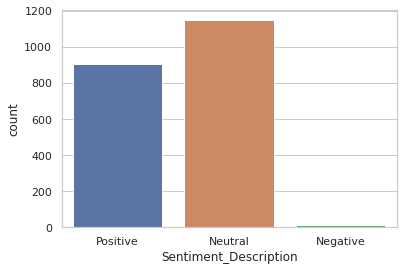

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment_Description', data=df_last)

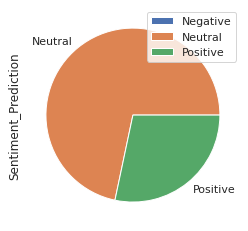

In [ ]:
import matplotlib.pyplot as  plt
df_last.groupby(['Sentiment_Description']).sum().plot(kind='pie', y='Sentiment_Prediction')